# Jet Lagged Demo

This file extracts all Jetlagged frontend code and loads in all necessary models.

To avoid manually pulling files into the runtime environment, add a shortcut to the JetLagged directory to your personal "My Drive" so files can be accessed via the path "~/JetLagged/"

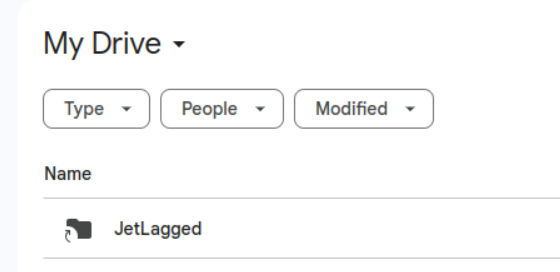

Execute the following cells to pip install and load necessary libraries


In [ ]:
%pip install noaa-sdk
#%pip install meteostat

In [ ]:
import pandas as pd
import numpy as np
from noaa_sdk import NOAA
from datetime import datetime, timedelta, date
import pytz
import re
import pickle
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Grant access to your Google account for the purposes of retrieving model data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import sys
# Get the current working directory
dir_path = '/content/gdrive/My Drive/JetLagged/data'
sys.path.append(dir_path)

# Forecasting Future Flights

Execute all cells

In [6]:
# read models
path = "{}/../models".format(dir_path)

#with open("{}/decision_tree.pkl".format(path), "rb") as file:
#    tree = pickle.load(file)
#with open("{}/logistic.pkl".format(path), "rb") as file:
#    logreg = pickle.load(file)
with open("{}/rforest_dashboard.pkl".format(path), "rb") as file:
    rf_classifier = pickle.load(file)
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.load_model("{}/xgb_dashboard.model".format(path))
#with open("{}/ocsvm.pkl".format(path), "rb") as file:
#    ocsvm = pickle.load(file)

In [7]:
# for future transformations
def transform_new_data(new_dat) :
    saved_scalar = joblib.load('{}/scaler_dashboard.pkl'.format(path))
    new_dat_df = pd.DataFrame(new_dat, columns=features)
    new_scaled = saved_scalar.transform(new_dat_df)
    return new_scaled

In [8]:
# commeted out previous for preprocessing, adding back
airport_info_df = pd.read_csv("{}/raw/airports_info.csv".format(dir_path))
airport_info_df = airport_info_df[['code', 'latitude','longitude', 'elevation','time_zone']]
airports = airport_info_df['code'].values

In [9]:
features = ['elevation', 'temp', 'dwpt', 'rhum', 'precip_chance', 'wdir', 'wspd', 'gust']

# conversions Fahrenheit to Celsius
def mph_to_kph(mph):
  return mph * 1.60934

def f_to_c(f):
  return (f - 32) * 5 / 9

# getting windspeed from string
def extract_wind_data(wind_speed_str):
  match = re.search(r'(\d+)\s*(?:to)\s*(\d+)', wind_speed_str)
  if match:
    windspeed = int(match.group(1))
    gust = int(match.group(2))
  else:
    match = re.search(r'(\d+)', wind_speed_str)
    if match:
      windspeed = int(match.group(1))
      gust = windspeed
    else:
      windspeed = 0
      gust = 0
  return mph_to_kph(windspeed), mph_to_kph(gust)

# Magnus formula and estimates dew point when the data isn't available
def dew_point_estimate(temp_c, humidity):
  a = 17.27
  b = 237.7
  gamma = math.log(humidity / 100) + (a * temp_c) / (b + temp_c)
  dew_point_c = (b * gamma) / (a - gamma)
  return dew_point_c

# Converting cardinal direction to degrees
# (e.g. N -> 0, W -> 270, etc.)
def direction_to_degrees(direction: str) -> float:
    cardinal_map = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }
    return cardinal_map.get(direction.upper(), None)  # Returns None if the direction is invalid


In [10]:
n = NOAA()

def get_airport_forecast(airport_code, forecast_hours):

  airport_code = airport_code.upper()
  # make sure the airport exists
  if len(airport_info_df[airport_info_df['code'] == airport_code]) == 0:
    print("Airport not found")
    return None

  # get airport attributes
  lat = airport_info_df[airport_info_df['code'] == airport_code]['latitude'].values[0]
  lon = airport_info_df[airport_info_df['code'] == airport_code]['longitude'].values[0]
  elev = airport_info_df[airport_info_df['code'] == airport_code]['elevation'].values[0]

  # features = ['elevation', 'temp', 'dwpt', 'rhum', 'precip_chance', 'wdir', 'wspd', 'gust']

  # get forecast
  forecast = n.points_forecast(lat, lon, type='forecastHourly')
  forecast_vectors = []
  for t in range(forecast_hours):
    temp_t = f_to_c(forecast['properties']['periods'][t]['temperature'])
    humidity_t = forecast['properties']['periods'][t]['relativeHumidity']['value']
    dewpoint_t = forecast['properties']['periods'][t]['dewpoint']['value'] if forecast['properties']['periods'][t]['dewpoint'] else dew_point_estimate(temp, humidity)
    precip_t = forecast['properties']['periods'][t]['probabilityOfPrecipitation']['value'] if forecast['properties']['periods'][t]['probabilityOfPrecipitation'] else 0
    wdir_t = direction_to_degrees(forecast['properties']['periods'][t]['windDirection']) if forecast['properties']['periods'][t]['windDirection'] else 0
    windspeed_t, gust_t = extract_wind_data(forecast['properties']['periods'][t]['windSpeed'])

    forecast_vectors.append([elev, temp_t, dewpoint_t, humidity_t, precip_t, wdir_t, windspeed_t, gust_t])

  return forecast_vectors

In [11]:
def delay_expectation_xgb(airport_code, forecast_hours, sigmoid):
  forecast = get_airport_forecast(airport_code, forecast_hours)
  prob_delay = []
  for f in forecast:
    vctr = transform_new_data(np.array(f).reshape(1, -1))
    if sigmoid:
      prob_delay.append((xgb_classifier.predict(vctr, output_margin=False))[0])
    else:
      prob_delay.append((xgb_classifier.predict(vctr, output_margin=True))[0])
  return prob_delay

In [12]:
def delay_expectation_rf(airport_code, forecast_hours):
  forecast = get_airport_forecast(airport_code, forecast_hours)
  prob_delay = []
  for f in forecast:
    vctr = transform_new_data(np.array(f).reshape(1, -1))
    prob_delay.append((rf_classifier.predict(vctr))[0])
  return prob_delay

In [13]:
def plot_delay_forecast(delays, airport, sigmo):
    eastern = pytz.timezone("US/Eastern")
    current_time = datetime.now(eastern)

    start_time = current_time.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)

    times = [start_time + timedelta(hours=i) for i in range(len(delays))]

    plt.figure(figsize=(12, 6))
    plt.plot(times, delays, drawstyle="steps-post", marker='o', color='orange', linestyle='-', label="Delay Likelihood")

    if not sigmo:
      plt.yticks([0, 1], ['No Delay', 'Likely Delay'])
      plt.ylim(-0.1, 1.1)
    else:
      plt.yticks([0], ['Decision Boundary'])
      lim = max(abs(min(delays)), max(delays))
      plt.ylim(-lim-0.1, lim+0.1)
    plt.xlabel("Time (Eastern)")
    plt.xticks(rotation=90)

    plt.ylabel("Likelihood of Delay")
    plt.title(f"Forecasted Flight Delay Likelihood at {airport}")
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.legend()

    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I %p', tz=eastern))

    plt.tight_layout()
    plt.show()

Input a 3-digit airport code, select a forecasting window in hours, and run cell for an estimation of delays at the given airport

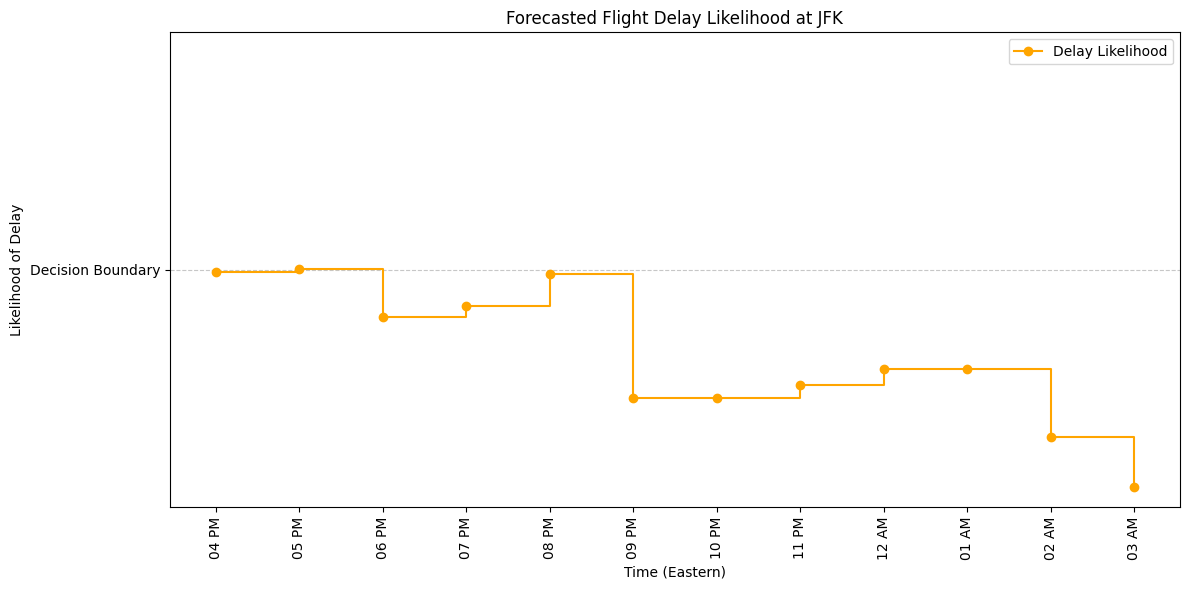

In [15]:
# @title Run Forecast
airport_code = "JFK" # @param {"type":"string","placeholder":"JFK"}
forecast_hours = 12 # @param {"type":"slider","min":1,"max":100,"step":1}
sigmoid = False # @param {"type":"boolean"}
model_type = "XGBoost" # @param ["Random Forest","XGBoost"]
plot = True

if model_type == "Random Forest" and airport_code in airports:
  airport_forecast = delay_expectation_rf(airport_code, forecast_hours)
elif model_type == "XGBoost" and airport_code in airports:
  airport_forecast = delay_expectation_xgb(airport_code, forecast_hours, sigmoid)
else :
  plot = False
  print("something went wrong")
plot_delay_forecast(airport_forecast, airport_code, (model_type == "XGBoost" and not sigmoid))